# Anticipez les besoins en consommations de bâtiments

## Etape 3 - Préparez les features pour la modélisation

### Reprendre les éléments de notre notebook de l'étape 2

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
building_clean_trois = pd.read_csv("Data/Projet_3_etape2_clean.csv")

#### Après autant de changements on peut regarder notre jeu de données et vérifier quelques basiques.

* Petit récapitulatif

In [2]:
data_avant_transformation = building_clean_trois.shape
print('Nous retrouvons',data_avant_transformation[0],'lignes et nous avons',data_avant_transformation[1],'colonnes avant le nettoyage des données avant transformation.')

Nous retrouvons 1601 lignes et nous avons 20 colonnes avant le nettoyage des données avant transformation.


In [3]:
building_clean_trois.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601 entries, 0 to 1600
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   OSEBuildingID           1601 non-null   int64  
 1   BuildingType            1601 non-null   object 
 2   PrimaryPropertyType     1601 non-null   object 
 3   Neighborhood            1601 non-null   object 
 4   NumberofBuildings       1601 non-null   float64
 5   NumberofFloors          1601 non-null   int64  
 6   PropertyGFATotal        1601 non-null   int64  
 7   PropertyGFAParking      1601 non-null   int64  
 8   LargestPropertyUseType  1601 non-null   object 
 9   SiteEnergyUse(kBtu)     1601 non-null   float64
 10  UsageType               1601 non-null   object 
 11  NumPropertyUseTypes     1601 non-null   int64  
 12  BuildingAge             1601 non-null   int64  
 13  HasSteam                1601 non-null   int64  
 14  HasElectricity          1601 non-null   

* Petit récapitulatif

### Recommendation 1 : Si la méthode IQR ou z-score supprime trop de bâtiments outliers, utiliser des seuils sur la base de quantiles.

#### Afin de détecter des valeurs abérrantes on peut utiliser deux méthodes :
* IQR
* z-score

#### Commençons par le Z-Score
Le Z-score, aussi appelé score Z ou score standard, est une mesure statistique qui décrit la position d'une valeur donnée par rapport à la moyenne d'un groupe de valeurs, position mesurée en fonction de l'écart-type.

In [4]:
# On applique la méthode z-score
from scipy import stats
building_clean_trois['z_target'] = stats.zscore(building_clean_trois["SiteEnergyUse(kBtu)"])

* On regarde la distribution de la méthode z-score

Text(0.5, 1.0, 'Distribution du Z-Score de SiteEnergyUse (notre target)')

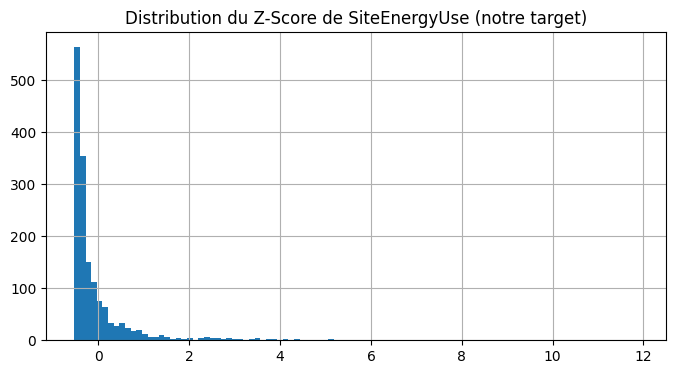

In [5]:
building_clean_trois['z_target']

plt.figure(figsize=(8,4))
building_clean_trois['z_target'].hist(bins = 100)
,kde=True, bins=10)
plt.title("Distribution du Z-Score de SiteEnergyUse (notre target)")


* On retrouve des valeurs abrérrantes avec un z-score à plus de 2 ou 3. On peut regarder dans le détail

In [6]:
print((building_clean_trois['z_target']>=2).value_counts())
print((building_clean_trois['z_target']<=-2).value_counts())


z_target
False    1531
True       70
Name: count, dtype: int64
z_target
False    1601
Name: count, dtype: int64


* On retrouve beaucoup de valeurs au dessus de 2 (70 valeurs). Nous ne sommes pas dans le cadre d'une distribution normale (vu avec les graphiques de l'étape 1) mais on peut regarder de nouveau la distribution de notre target pour s'en assurer.

#### Distribution et Boxplot de notre target, SiteEnergyUse

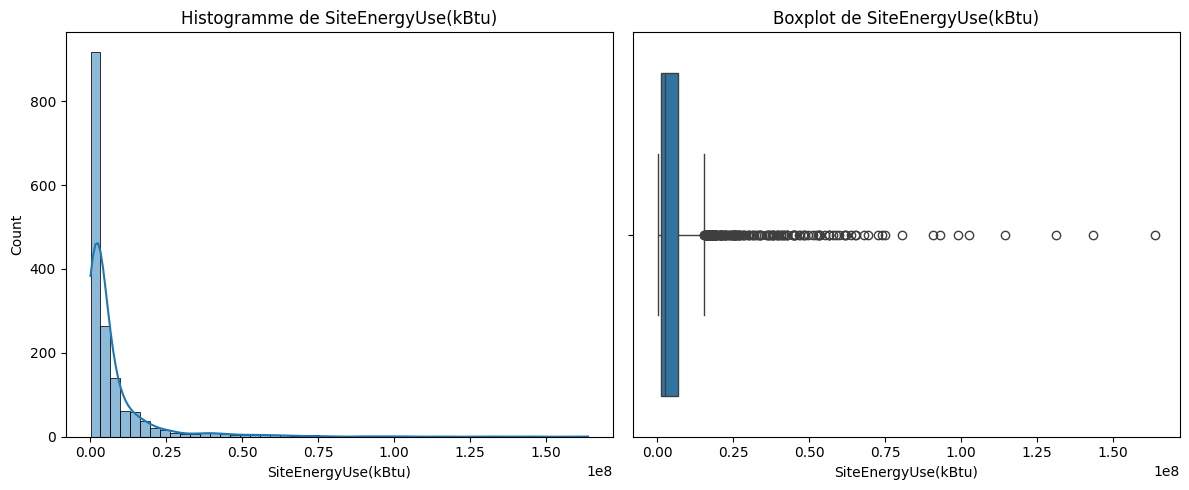

In [7]:
plt.figure(figsize=(12, 5))

# Histogramme
plt.subplot(1, 2, 1)
sns.histplot(building_clean_trois["SiteEnergyUse(kBtu)"], bins=50, kde=True)
plt.title("Histogramme de SiteEnergyUse(kBtu)")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=building_clean_trois["SiteEnergyUse(kBtu)"])
plt.title("Boxplot de SiteEnergyUse(kBtu)")

plt.tight_layout()
plt.show()

* Nous ne sommes pas face à une distribution normale, la méthode z-score suppose une distribution normale et est sensible aux valeurs extrêmes alors nous allons regarder du côté de la méthode IQR.

* La colonne z_target s'est ajouté, on peut la supprimer directement

In [8]:
building_clean_trois = building_clean_trois.drop(columns='z_target')

* Petit récapitulatif

In [9]:
data_avant_transformation_un = building_clean_trois.shape
print('Nous retrouvons',data_avant_transformation[0],'lignes et nous avons',data_avant_transformation[1],'colonnes avant le nettoyage des données avant transformation.')
print('Nous retrouvons',data_avant_transformation_un[0],'lignes et nous avons',data_avant_transformation_un[1],'colonnes après suppression de la colonne z_target.')

Nous retrouvons 1601 lignes et nous avons 20 colonnes avant le nettoyage des données avant transformation.
Nous retrouvons 1601 lignes et nous avons 20 colonnes après suppression de la colonne z_target.


#### Méthode IQR

L'écart interquartile (IQR) est une mesure de la dispersion, basée sur la division de l'ensemble de données en quartiles. Les quartiles divisent un ensemble de données classé en quatre parties égales.
Ici on va appliquer un calcul sur l'IQR, limite haute et basse pour identifier des valeurs abrérrantes/extrêmes.
* inférieures à Q1 - 1,5 * IQR 
* ou supérieures à Q3 + 1,5 * IQR 

In [10]:
# J'applique la méthode à ma varibale cible
iqr = np.quantile(building_clean_trois["SiteEnergyUse(kBtu)"], q=[0.25, 0.75])
limite_basse = iqr[0] - 1.5*(iqr[1] - iqr[0])
limite_haute = iqr[1] + 1.5*(iqr[1] - iqr[0])

In [11]:
print("La limite haute est de",limite_haute,"et la limite basse est de",limite_basse)

La limite haute est de 15360532.125 et la limite basse est de -7196742.875


In [12]:
(building_clean_trois["SiteEnergyUse(kBtu)"]>=limite_haute).value_counts()

SiteEnergyUse(kBtu)
False    1424
True      177
Name: count, dtype: int64

* On retrouve dans cette méthode encore beaucoup d'outliers
* En regardant sur les blogs, j'ai vu qu'il était possible d'utiliser une fonction logarithmique pour rendre la distribution normale.
* Avant de faire quoi que ce soit, nous pouvons regarder notre IQR sans l'application des calculs de limite en fixant nous même notre seuil

#### Utilisation des seuils sur la base de quantiles.

* On définit un seuil le plus cohérent possible pour éviter de supprimer trop de données

In [13]:
iqr = np.quantile(building_clean_trois["SiteEnergyUse(kBtu)"], q=[0.05, 0.95])
iqr


array([  439266.9063, 28053172.    ])

In [14]:
(building_clean_trois["SiteEnergyUse(kBtu)"]>iqr[1]).value_counts()

SiteEnergyUse(kBtu)
False    1521
True       80
Name: count, dtype: int64

In [15]:
(building_clean_trois["SiteEnergyUse(kBtu)"]<iqr[0]).value_counts()

SiteEnergyUse(kBtu)
False    1521
True       80
Name: count, dtype: int64

#### On retouve encore beaucoup de valeurs extrêmes ou abérrantes. Regardons dans le détail.

#### Regardons la limite haute avec des variables qui peuvent potentiellement expliquer les écarts

In [16]:
building_clean_trois.loc[
    building_clean_trois["SiteEnergyUse(kBtu)"] > iqr[1],
    ['PrimaryPropertyType', 'SiteEnergyUse(kBtu)','NumberofFloors','PropertyGFATotal','AreaPerFloor']
].head(15)

,PrimaryPropertyType,SiteEnergyUse(kBtu),NumberofFloors,PropertyGFATotal,AreaPerFloor
2,Hotel,72587024.0,41,956110,23319.756098
16,Hotel,33556756.0,28,416281,14867.178571
19,Other,44984468.0,10,540360,54036.000000
20,Other,47859812.0,19,385274,20277.578947
32,Warehouse,44731160.0,2,714095,357047.500000
45,Hotel,80469216.0,34,994212,29241.529412
55,Senior Care Community,42792072.0,5,217603,43520.600000
67,Large Office,39605888.0,12,571329,47610.750000
72,Large Office,36667044.0,6,920598,153433.000000
90,Hospital,68090728.0,5,285333,57066.600000


* Effectivement la consommation est grande mais on ne remarque rien d'abérrant, compte tenu de leur intitulé, ce ne sont pas des erreurs. On remarque que ce sont des catégories comme les hôtels, les grosses entreprises, des hôpitaux, des universités que l'on retrouvent. Certains ont plus de 40 étages. On ne peut donc pas les supprimer.

#### Regardons la limite basse

In [17]:
building_clean_trois.loc[
    building_clean_trois["SiteEnergyUse(kBtu)"] < iqr[0],
    ['PrimaryPropertyType', 'SiteEnergyUse(kBtu)','NumberofFloors','PropertyGFATotal','AreaPerFloor']
].head(15)

,PrimaryPropertyType,SiteEnergyUse(kBtu),NumberofFloors,PropertyGFATotal,AreaPerFloor
31,Self-Storage Facility,318364.81250,2,110356,55178.000000
135,Warehouse,430473.68750,2,50292,25146.000000
356,Warehouse,227566.70310,2,63240,31620.000000
362,Warehouse,402051.31250,1,22780,22780.000000
371,Warehouse,325513.00000,3,64660,21553.333333
561,Distribution Center,151754.29690,1,71718,71718.000000
617,Warehouse,345866.68750,1,30375,30375.000000
618,Warehouse,369291.50000,1,30004,30004.000000
640,University,323739.40630,3,21600,7200.000000
656,Mixed Use Property,418348.50000,2,28696,14348.000000


* Ici aussi, on ne retrouve pas des erreurs mais des petites structures. On le remarque avec leur intitulé mais également le nombre de mètres carrés est bas pour beaucoup d'entre eux, ce qui peut induire une plus petite consommation d'énergie.

#### Afin de gérer la grande amplitude de notre target, on va lui appliquer une fonction logarithmique.

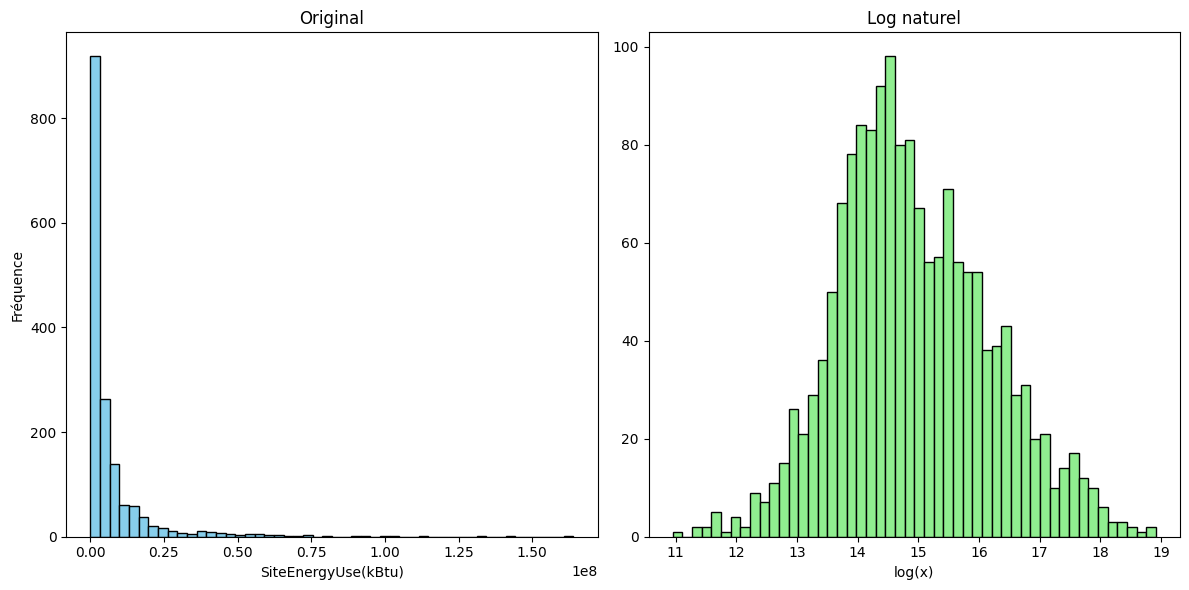

In [18]:
building_clean_trois['SiteEnergyUse_log'] = np.log(building_clean_trois['SiteEnergyUse(kBtu)'])

building_clean_trois = building_clean_trois[building_clean_trois['SiteEnergyUse(kBtu)'] > 0]


plt.figure(figsize=(12, 6))

# Histogramme original
plt.subplot(1, 2, 1)
plt.hist(building_clean_trois['SiteEnergyUse(kBtu)'], bins=50, color='skyblue', edgecolor='black')
plt.title('Original')
plt.xlabel('SiteEnergyUse(kBtu)')
plt.ylabel('Fréquence')

# Histogramme log
plt.subplot(1, 2, 2)
plt.hist(building_clean_trois['SiteEnergyUse_log'], bins=50, color='lightgreen', edgecolor='black')
plt.title('Log naturel')
plt.xlabel('log(x)')


plt.tight_layout()
plt.show()

* Grâce à cette transformation, on voit que notre distribution est mieux répartie. Elle n'est plus étalée à droite comme la donnée orginale

#### Vérifions avec un boxplot

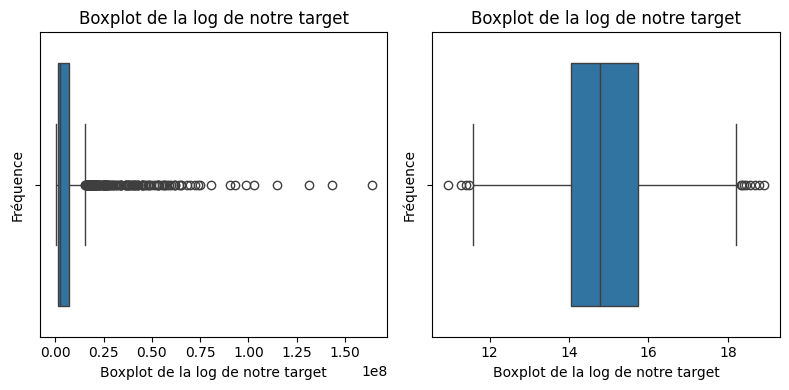

In [19]:
plt.figure(figsize=(8,4))

plt.subplot(1, 2, 1)
sns.boxplot(data=building_clean_trois, x=building_clean_trois['SiteEnergyUse(kBtu)'])
plt.title("Boxplot de la log de notre target")
plt.xlabel("Boxplot de la log de notre target")
plt.ylabel('Fréquence')
  
    
plt.subplot(1, 2, 2)
sns.boxplot(data=building_clean_trois,x=building_clean_trois['SiteEnergyUse_log'])
plt.title("Boxplot de la log de notre target")
plt.xlabel("Boxplot de la log de notre target")
plt.ylabel('Fréquence')
 

plt.tight_layout()
plt.show()

On voit une nette amélioration avec des données plus utilisables. Nous avons la présence de valeurs extrêmes mais pas abérrantes, on doit donc les garder

#### On applique de nouveau la méthode IQR pour se rassurer quant aux résultats

In [20]:
# J'applique la méthode à ma varibale cible
iqr = np.quantile(building_clean_trois['SiteEnergyUse_log'], q=[0.25, 0.75])
limite_basse = iqr[0] - 1.5*(iqr[1] - iqr[0])
limite_haute = iqr[1] + 1.5*(iqr[1] - iqr[0])

* Vérification de la limite haute

In [21]:
(building_clean_trois['SiteEnergyUse_log']>=limite_haute).value_counts()

SiteEnergyUse_log
False    1593
True        8
Name: count, dtype: int64

* Vérification des 8 valeurs

In [22]:
building_clean_trois.loc[building_clean_trois['SiteEnergyUse_log']>=limite_haute,:]

,OSEBuildingID,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseType,SiteEnergyUse(kBtu),...,NumPropertyUseTypes,BuildingAge,HasSteam,HasElectricity,HasGas,NbSourcesEnergies,SecondUseRatio,ThirdUseRatio,AreaPerFloor,SiteEnergyUse_log
153,268,NonResidential,Hospital,CENTRAL,6.0,5,597519,0,Hospital (General Medical & Surgical),143423024.0,...,2,26,0,1,1,2,0.081348,0.000000,1.195038e+05,18.781309
318,477,Campus,Other,LAKE_UNION,1.0,5,535947,0,Other,131373880.0,...,2,19,0,1,1,2,0.194017,0.000000,1.071894e+05,18.693558
526,775,NonResidential,Large Office,DOWNTOWN,1.0,76,1952220,319400,Office,92937640.0,...,2,31,0,1,1,2,0.163592,0.000000,2.568711e+04,18.347439
943,22062,Campus,University,EAST,1.0,2,2200000,0,College/University,114648520.0,...,2,77,0,1,1,2,0.144982,0.000000,1.100000e+06,18.557382
1015,23071,NonResidential,Hospital,NORTHWEST,8.0,1,415632,0,Hospital (General Medical & Surgical),98960776.0,...,2,50,0,1,1,2,0.641993,0.000000,4.156320e+05,18.410234
1018,23113,NonResidential,Medical Office,EAST,1.0,3,591981,0,Medical Office,102673696.0,...,4,52,0,1,1,2,0.477029,0.091488,1.973270e+05,18.447067
1269,25251,Campus,University,MAGNOLIA_QUEENANNE,14.0,2,537000,0,College/University,90609640.0,...,1,71,0,1,1,2,0.000000,0.000000,2.685000e+05,18.322071
1556,49940,NonResidential,Hospital,EAST,1.0,8,374466,0,Hospital (General Medical & Surgical),163945984.0,...,1,96,1,1,0,2,0.000000,0.000000,4.680825e+04,18.915048


* Les données ne semblent pas contenir des erreurs. Par exemple nous avons vérifié la valeur du campus avec une grosse consommation énergétique. Le nombre de GFA est vraie (vérifié sur wikipédia), donc on peut comprendre sa consommation.

* Vérification de la limite basse

In [23]:
(building_clean_trois['SiteEnergyUse_log']<=limite_basse).value_counts()

SiteEnergyUse_log
False    1597
True        4
Name: count, dtype: int64

In [24]:
building_clean_trois.loc[building_clean_trois['SiteEnergyUse_log']<=limite_basse,:]

,OSEBuildingID,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseType,SiteEnergyUse(kBtu),...,NumPropertyUseTypes,BuildingAge,HasSteam,HasElectricity,HasGas,NbSourcesEnergies,SecondUseRatio,ThirdUseRatio,AreaPerFloor,SiteEnergyUse_log
707,20396,NonResidential,Warehouse,DOWNTOWN,1.0,5,33300,0,Non-Refrigerated Warehouse,90558.70313,...,2,116,0,1,0,1,0.18018,0.0,6660.000000,11.413754
974,22547,NonResidential,Self-Storage Facility,MAGNOLIA_QUEENANNE,1.0,3,30989,0,Self-Storage Facility,97690.39844,...,1,36,0,1,0,1,0.00000,0.0,10329.666667,11.489559
975,22548,NonResidential,Self-Storage Facility,MAGNOLIA_QUEENANNE,1.0,3,39952,0,Self-Storage Facility,57133.19922,...,1,101,0,1,0,1,0.00000,0.0,13317.333333,10.953141
1466,27869,NonResidential,Warehouse,EAST,1.0,2,23040,0,Non-Refrigerated Warehouse,79711.79688,...,1,96,0,1,1,2,0.00000,0.0,11520.000000,11.286173


* A partir des données de gross floor area, on peut comprendre la faible consommation en énergie

#### On retrouve que 8 valeurs ici, comparé aux 177 valeurs, la transformation est donc concluante

In [25]:
data_avant_transformation_deux = building_clean_trois.shape
print('Nous retrouvons',data_avant_transformation[0],'lignes et nous avons',data_avant_transformation[1],'colonnes avant le nettoyage des données avant transformation.')
print('Nous retrouvons',data_avant_transformation_un[0],'lignes et nous avons',data_avant_transformation_un[1],'colonnes après suppression de la colonne z_target.')
print('Nous retrouvons',data_avant_transformation_deux[0],'lignes et nous avons',data_avant_transformation_deux[1],'colonnes ajout de la colonne log de notre target.')

Nous retrouvons 1601 lignes et nous avons 20 colonnes avant le nettoyage des données avant transformation.
Nous retrouvons 1601 lignes et nous avons 20 colonnes après suppression de la colonne z_target.
Nous retrouvons 1601 lignes et nous avons 21 colonnes ajout de la colonne log de notre target.


In [26]:
building_clean_trois.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseType,SiteEnergyUse(kBtu),...,NumPropertyUseTypes,BuildingAge,HasSteam,HasElectricity,HasGas,NbSourcesEnergies,SecondUseRatio,ThirdUseRatio,AreaPerFloor,SiteEnergyUse_log
0,1,NonResidential,Hotel,DOWNTOWN,1.0,12,88434,0,Hotel,7226362.5,...,1,89,1,1,1,3,0.000000,0.000000,7369.500000,15.793246
1,2,NonResidential,Hotel,DOWNTOWN,1.0,11,103566,15064,Hotel,8387933.0,...,3,20,0,1,1,2,0.145453,0.044629,9415.090909,15.942305
2,3,NonResidential,Hotel,DOWNTOWN,1.0,41,956110,196718,Hotel,72587024.0,...,1,47,1,1,1,3,0.000000,0.000000,23319.756098,18.100297
3,5,NonResidential,Hotel,DOWNTOWN,1.0,10,61320,0,Hotel,6794584.0,...,1,90,1,1,1,3,0.000000,0.000000,6132.000000,15.731636
4,8,NonResidential,Hotel,DOWNTOWN,1.0,18,175580,62000,Hotel,14172606.0,...,3,36,0,1,1,2,0.387339,0.000000,9754.444444,16.466822


### Recommendation 2 : Dégager des tendances dans vos données (par exemple, quand la feature prend X valeurs, on observe tel comportement de la target).

Nos colonnes numériques à utiliser

In [28]:
cols = [
    'NumberofBuildings','NumberofFloors',
    'PropertyGFATotal','BuildingAge','NbSourcesEnergies','AreaPerFloor'
    ]

#### Relation entre nos variables et la target

##### Relation entre Consommation totale d’énergie (log) et le nombre de bâtiments & Relation entre Consommation totale d’énergie (log) et le nombre d'étages

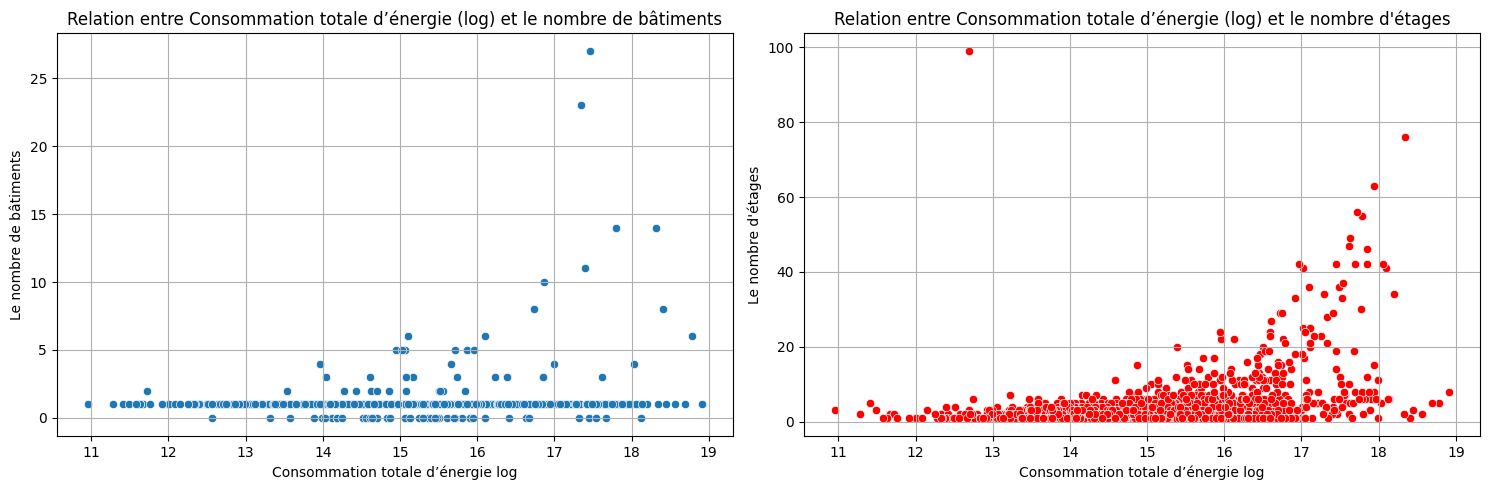

In [39]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

plt.subplot(1,2,1)
sns.scatterplot(x = building_clean_trois['SiteEnergyUse_log'], y = building_clean_trois['NumberofBuildings'])
plt.title("Relation entre Consommation totale d’énergie (log) et le nombre de bâtiments")
plt.xlabel("Consommation totale d’énergie log")
plt.ylabel("Le nombre de bâtiments")
plt.grid(True)

plt.subplot(1,2,2)
sns.scatterplot(x = building_clean_trois['SiteEnergyUse_log'], y = building_clean_trois['NumberofFloors'], color = 'red')
plt.title("Relation entre Consommation totale d’énergie (log) et le nombre d'étages")
plt.xlabel("Consommation totale d’énergie log")
plt.ylabel("Le nombre d'étages")
plt.grid(True)

plt.tight_layout()
plt.show()

Relation entre Consommation totale d’énergie et le nombre de bâtiments :
* Le nombre de bâtiments augmente très légèrement avec la consommation d'énergie (log).

Relation entre Consommation totale d’énergie et le nombre d'étages :
* On voit de manière générale une petite hausse de consommation énergétique (log) plus il y a d'étages. Cela se vérifie un peu plus avec des bâtiments de plus de 25 étages.

##### Relation entre Consommation totale d’énergie (log) et l'âge des bâtiments & Relation entre Consommation totale d’énergie et la superficie totale (log)

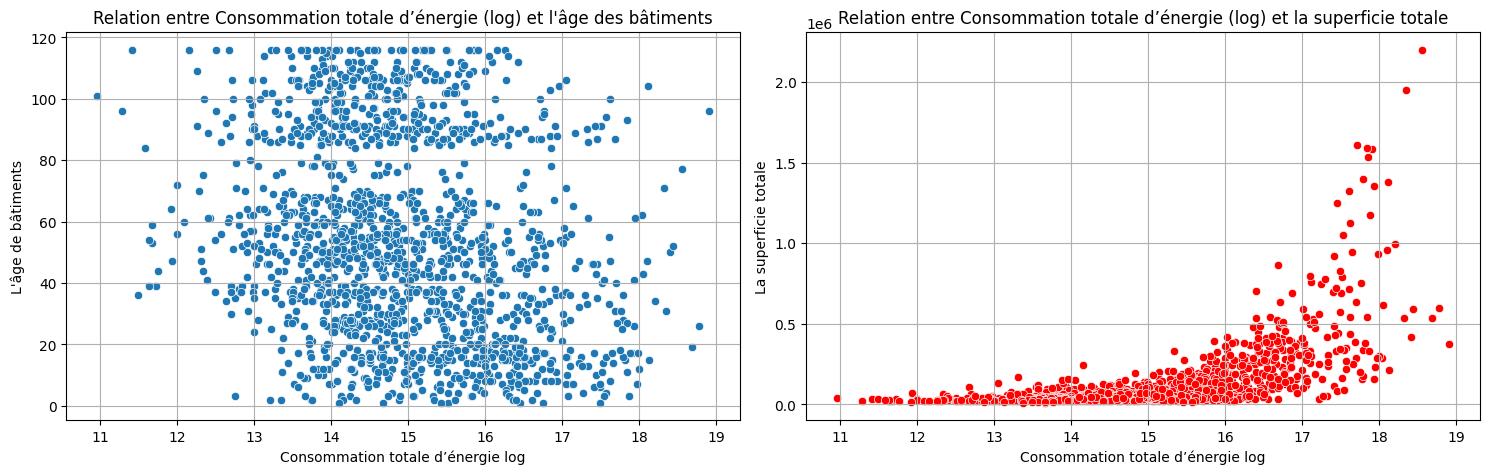

In [40]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

plt.subplot(1,2,1)
sns.scatterplot(x = building_clean_trois['SiteEnergyUse_log'], y = building_clean_trois['BuildingAge'])
plt.title("Relation entre Consommation totale d’énergie (log) et l'âge des bâtiments")
plt.xlabel("Consommation totale d’énergie log")
plt.ylabel("L'âge de bâtiments")
plt.grid(True)

plt.subplot(1,2,2)
sns.scatterplot(x = building_clean_trois['SiteEnergyUse_log'], y = building_clean_trois['PropertyGFATotal'], color = 'red')
plt.title("Relation entre Consommation totale d’énergie (log) et la superficie totale")
plt.xlabel("Consommation totale d’énergie log")
plt.ylabel("La superficie totale")
plt.grid(True)

plt.tight_layout()
plt.show()

Relation entre Consommation totale d’énergie et l'âge des bâtiments :
* Pas de relation entre les deux, la consommation n'évolue pas en fonction de l'âge des bâtiments

Relation entre Consommation totale d’énergie et la superficie totale
* Plus la superficie augmente plus la consommation énergétique augmente

##### Relation entre Consommation totale d’énergie (log) et le nombre de sources d'énergies & Relation entre Consommation totale d’énergie et la superficie par étage

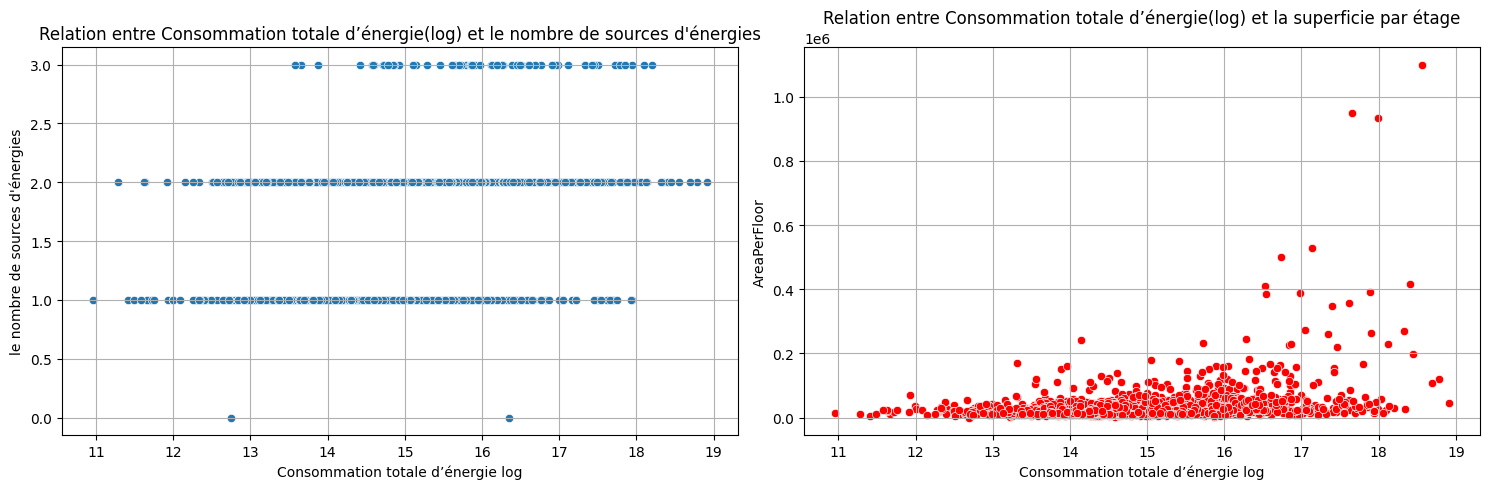

In [41]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

plt.subplot(1,2,1)
sns.scatterplot(x = building_clean_trois['SiteEnergyUse_log'], y = building_clean_trois['NbSourcesEnergies'])
plt.title("Relation entre Consommation totale d’énergie(log) et le nombre de sources d'énergies")
plt.xlabel("Consommation totale d’énergie log")
plt.ylabel("le nombre de sources d'énergies")
plt.grid(True)

plt.subplot(1,2,2)
sns.scatterplot(x = building_clean_trois['SiteEnergyUse_log'], y = building_clean_trois['AreaPerFloor'], color = 'red')
plt.title("Relation entre Consommation totale d’énergie(log) et la superficie par étage")
plt.xlabel("Consommation totale d’énergie log")
plt.ylabel("AreaPerFloor")
plt.grid(True)

plt.tight_layout()
plt.show()

Relation entre Consommation totale d’énergie et le nombre de sources d'énergies :
* Pas de relation particulière entre le nombre de sources d'énergie et la consommation. Alors que l'on aurait pu penser que plus de sources d'énergie impliquent une plus grande consommation.

Relation entre Consommation totale d’énergie et la superficie par étage :
* Relation monotone entre les deux, la superficie par étage n'influence pas la consommation de manière saisissante (juste quelques uns)


##### Relation entre Consommation totale d’énergie (log) et la superficie des parkings & Relation entre Consommation totale d’énergie et la superficie du SecondUseRatio

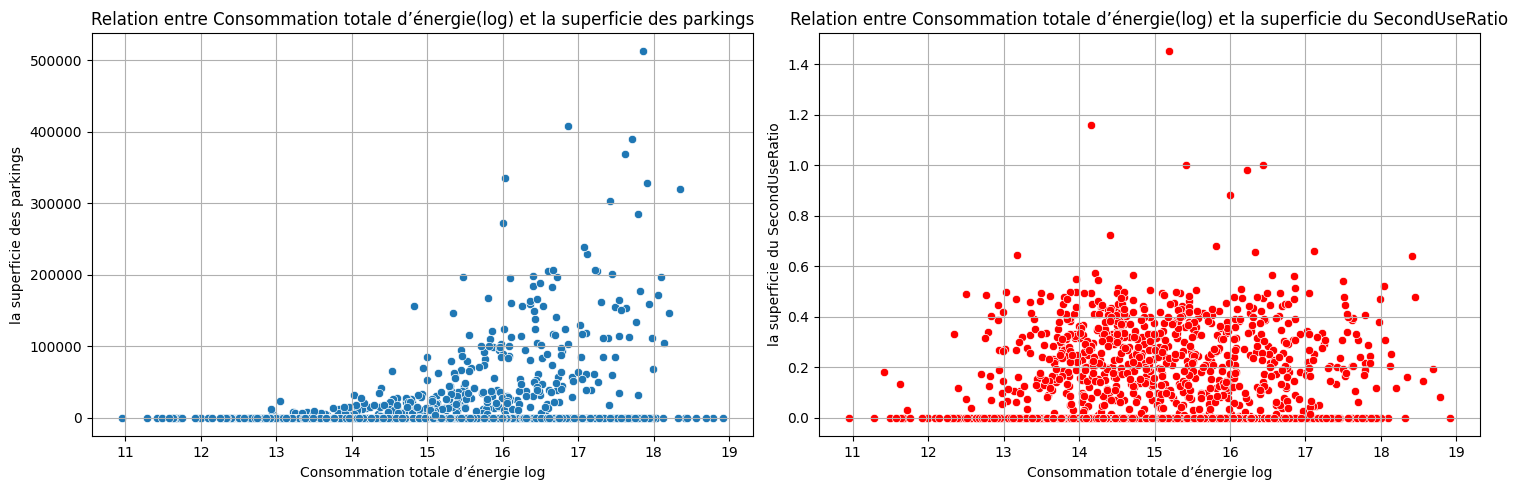

In [42]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

plt.subplot(1,2,1)
sns.scatterplot(x = building_clean_trois['SiteEnergyUse_log'], y = building_clean_trois['PropertyGFAParking'])
plt.title("Relation entre Consommation totale d’énergie(log) et la superficie des parkings")
plt.xlabel("Consommation totale d’énergie log")
plt.ylabel("la superficie des parkings")
plt.grid(True)

plt.subplot(1,2,2)
sns.scatterplot(x = building_clean_trois['SiteEnergyUse_log'], y = building_clean_trois['SecondUseRatio'], color = 'red')
plt.title("Relation entre Consommation totale d’énergie(log) et la superficie du SecondUseRatio")
plt.xlabel("Consommation totale d’énergie log")
plt.ylabel("la superficie du SecondUseRatio")
plt.grid(True)

plt.tight_layout()
plt.show()

Relation entre Consommation totale d’énergie et la superficie des parkings :
* On voit que la superficie des parkings fait augmenter notre consommation d'énergie

Relation entre Consommation totale d’énergie et la superficie du SecondUseRatio :
* Relation monotone entre les deux variables

#### Réalisation d'une heatmap pour voir de nouveau les relations de nos features avec notre target

* On retient nos variables pour la matrice :

In [44]:
col_corr_deux = [
    'NumberofBuildings','NumberofFloors','PropertyGFAParking',
    'PropertyGFATotal','BuildingAge','NbSourcesEnergies', 'NumPropertyUseTypes',
    'SecondUseRatio','ThirdUseRatio','AreaPerFloor','SiteEnergyUse(kBtu)'
    ]

In [45]:
building_clean_trois.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601 entries, 0 to 1600
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   OSEBuildingID           1601 non-null   int64  
 1   BuildingType            1601 non-null   object 
 2   PrimaryPropertyType     1601 non-null   object 
 3   Neighborhood            1601 non-null   object 
 4   NumberofBuildings       1601 non-null   float64
 5   NumberofFloors          1601 non-null   int64  
 6   PropertyGFATotal        1601 non-null   int64  
 7   PropertyGFAParking      1601 non-null   int64  
 8   LargestPropertyUseType  1601 non-null   object 
 9   SiteEnergyUse(kBtu)     1601 non-null   float64
 10  UsageType               1601 non-null   object 
 11  NumPropertyUseTypes     1601 non-null   int64  
 12  BuildingAge             1601 non-null   int64  
 13  HasSteam                1601 non-null   int64  
 14  HasElectricity          1601 non-null   

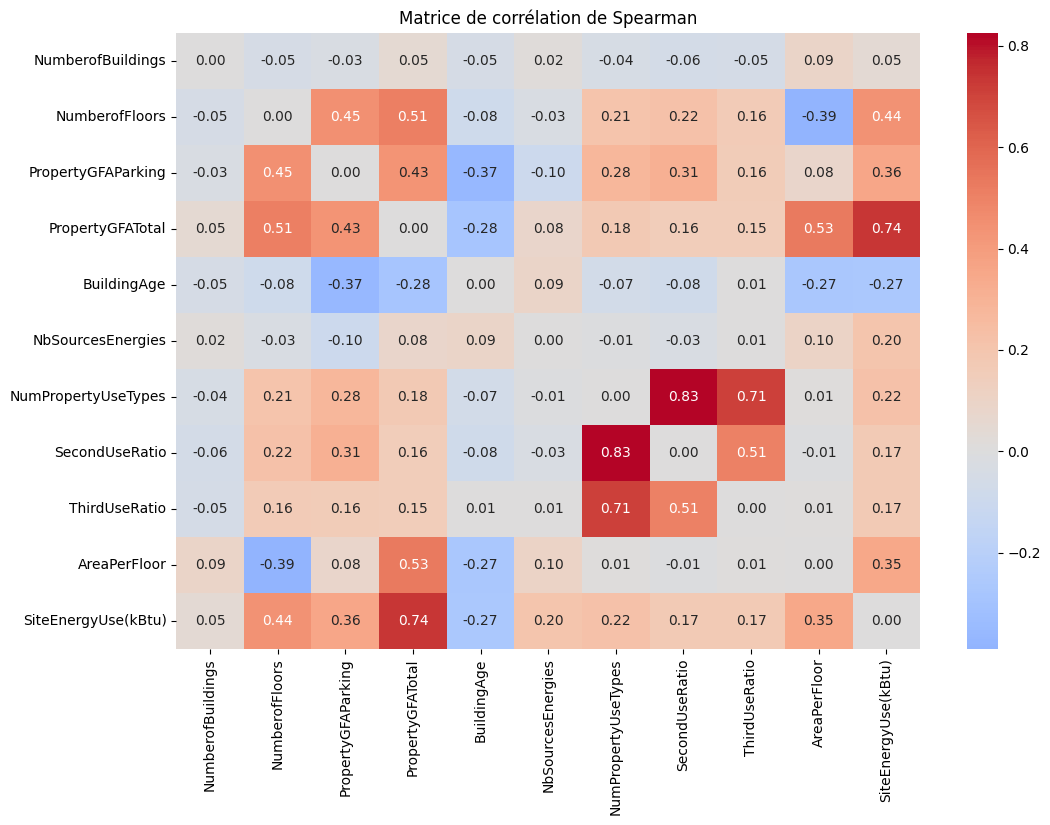

In [47]:
building_clean_trois_corr = building_clean_trois[col_corr_deux]
spearman_corr = building_clean_trois_corr.corr(numeric_only=True, method = 'spearman')
np.fill_diagonal(spearman_corr.values, 0)
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Matrice de corrélation de Spearman")
plt.show()

On voit quelques features correlés entre elles, mais celle qui mérite d'être enlevé est BuildingVolume car fortement correlé (plus de 0.70) avec NumPropertyUseTypes (qui est plus intéressant car présent dans notre dataframe original)

In [48]:
building_clean_trois = building_clean_trois.drop(columns = 'NumPropertyUseTypes')

* Petit récapitulatif

In [50]:
data_avant_transformation_trois = building_clean_trois.shape
print('Nous retrouvons',data_avant_transformation[0],'lignes et nous avons',data_avant_transformation[1],'colonnes avant le nettoyage des données avant transformation.')
print('Nous retrouvons',data_avant_transformation_un[0],'lignes et nous avons',data_avant_transformation_un[1],'colonnes après suppression de la colonne z_target.')
print('Nous retrouvons',data_avant_transformation_deux[0],'lignes et nous avons',data_avant_transformation_deux[1],'colonnes après suppression des outliers.')
print('Nous retrouvons',data_avant_transformation_trois[0],'lignes et nous avons',data_avant_transformation_trois[1],'colonnes après suppression de NumPropertyUseTypes.')

Nous retrouvons 1601 lignes et nous avons 20 colonnes avant le nettoyage des données avant transformation.
Nous retrouvons 1601 lignes et nous avons 20 colonnes après suppression de la colonne z_target.
Nous retrouvons 1601 lignes et nous avons 21 colonnes après suppression des outliers.
Nous retrouvons 1601 lignes et nous avons 20 colonnes après suppression de NumPropertyUseTypes.


#### Check de mon DataFrame

In [51]:
building_clean_trois.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601 entries, 0 to 1600
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   OSEBuildingID           1601 non-null   int64  
 1   BuildingType            1601 non-null   object 
 2   PrimaryPropertyType     1601 non-null   object 
 3   Neighborhood            1601 non-null   object 
 4   NumberofBuildings       1601 non-null   float64
 5   NumberofFloors          1601 non-null   int64  
 6   PropertyGFATotal        1601 non-null   int64  
 7   PropertyGFAParking      1601 non-null   int64  
 8   LargestPropertyUseType  1601 non-null   object 
 9   SiteEnergyUse(kBtu)     1601 non-null   float64
 10  UsageType               1601 non-null   object 
 11  BuildingAge             1601 non-null   int64  
 12  HasSteam                1601 non-null   int64  
 13  HasElectricity          1601 non-null   int64  
 14  HasGas                  1601 non-null   

#### Il est important de garder une colonne définissant le type de bâtiment. Le bon compromis est PrimaryPropertyType où l'on retrouve du détail sans créer trop de catégories (on anticipe pour l'encodage). On peut donc enlever BuildingType / LargestPropertyUseType.
#### Nos données sont nettoyées, on peut enlever OSEBuildingID qui nous servait de point de référence pour supprimer ou transformer des données.
#### Nous utilisons la version log de notre target donc nous pouvons enlever notre target initial SiteEnergyUse(kBtu). Nous transformerons de nouveau en unité Kbtu pour comparer les modèles

In [52]:
a_supprimer = ['BuildingType','LargestPropertyUseType','OSEBuildingID','SiteEnergyUse(kBtu)']
building_clean_trois = building_clean_trois.drop(columns=a_supprimer)
building_clean_trois.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601 entries, 0 to 1600
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PrimaryPropertyType  1601 non-null   object 
 1   Neighborhood         1601 non-null   object 
 2   NumberofBuildings    1601 non-null   float64
 3   NumberofFloors       1601 non-null   int64  
 4   PropertyGFATotal     1601 non-null   int64  
 5   PropertyGFAParking   1601 non-null   int64  
 6   UsageType            1601 non-null   object 
 7   BuildingAge          1601 non-null   int64  
 8   HasSteam             1601 non-null   int64  
 9   HasElectricity       1601 non-null   int64  
 10  HasGas               1601 non-null   int64  
 11  NbSourcesEnergies    1601 non-null   int64  
 12  SecondUseRatio       1601 non-null   float64
 13  ThirdUseRatio        1601 non-null   float64
 14  AreaPerFloor         1601 non-null   float64
 15  SiteEnergyUse_log    1601 non-null   f

* Petit récapitulatif

In [54]:
data_avant_transformation_quatre = building_clean_trois.shape
print('Nous retrouvons',data_avant_transformation[0],'lignes et nous avons',data_avant_transformation[1],'colonnes avant le nettoyage des données avant transformation.')
print('Nous retrouvons',data_avant_transformation_un[0],'lignes et nous avons',data_avant_transformation_un[1],'colonnes après suppression de la colonne z_target.')
print('Nous retrouvons',data_avant_transformation_deux[0],'lignes et nous avons',data_avant_transformation_deux[1],'colonnes après suppression des outliers.')
print('Nous retrouvons',data_avant_transformation_trois[0],'lignes et nous avons',data_avant_transformation_trois[1],'colonnes après suppression de NumPropertyUseTypes.')
print('Nous retrouvons',data_avant_transformation_quatre[0],'lignes et nous avons',data_avant_transformation_quatre[1],'colonnes après suppression de 4 colonnes non pertinentes.')

Nous retrouvons 1601 lignes et nous avons 20 colonnes avant le nettoyage des données avant transformation.
Nous retrouvons 1601 lignes et nous avons 20 colonnes après suppression de la colonne z_target.
Nous retrouvons 1601 lignes et nous avons 21 colonnes après suppression des outliers.
Nous retrouvons 1601 lignes et nous avons 20 colonnes après suppression de NumPropertyUseTypes.
Nous retrouvons 1601 lignes et nous avons 16 colonnes après suppression de 4 colonnes non pertinentes.


### Recommendation 3 : Bien comprendre dans quelle situation on utilise un OneHotEncoder au lieu d'un LabelEncoder et vice-versa. Au besoin, consulter le chapitre indiqué dans la rubrique Ressources.

### Encodage des variables catégorielles

#### Nous avons nettoyé nos données et créé nos features juste avant. Nous devons maintenant encoder nos variables catégorielles afin de les préparer pour la modélisation

#### On commence par PrimaryPropertyType

* On applique une fonction de OneHot Encoder via get dummies

In [55]:
building_clean_trois = pd.get_dummies(building_clean_trois, columns=["PrimaryPropertyType"], dtype=int)

* On vérifie l'intégration des nouvelles colonnes

In [56]:
building_clean_trois.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601 entries, 0 to 1600
Data columns (total 36 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Neighborhood                                     1601 non-null   object 
 1   NumberofBuildings                                1601 non-null   float64
 2   NumberofFloors                                   1601 non-null   int64  
 3   PropertyGFATotal                                 1601 non-null   int64  
 4   PropertyGFAParking                               1601 non-null   int64  
 5   UsageType                                        1601 non-null   object 
 6   BuildingAge                                      1601 non-null   int64  
 7   HasSteam                                         1601 non-null   int64  
 8   HasElectricity                                   1601 non-null   int64  
 9   HasGas                        

* On a bien nos nouvelles catégories
* Mais les noms des colonnes comportent des espaces pour certaines alors on va les modifier

In [57]:
building_clean_trois.rename(columns={
    "PrimaryPropertyType_Distribution Center": "PrimaryPropertyType_Distribution_Center",
    "PrimaryPropertyType_K-12 School": "PrimaryPropertyType_K_12_School",
    "PrimaryPropertyType_Large Office": "PrimaryPropertyType_Large_Office",
    "PrimaryPropertyType_Medical Office": "PrimaryPropertyType_Medical_Office",
    "PrimaryPropertyType_Mixed Use Property": "PrimaryPropertyType_Mixed_Use_Property",
    "PrimaryPropertyType_Refrigerated Warehouse": "PrimaryPropertyType_Refrigerated_Warehouse",
    "PrimaryPropertyType_Residence Hall": "PrimaryPropertyType_Residence_Hall",
    "PrimaryPropertyType_Retail Store": "PrimaryPropertyType_Retail_Store",
    "PrimaryPropertyType_Self-Storage Facility": "PrimaryPropertyType_Self_Storage_Facility",
    "PrimaryPropertyType_Senior Care Community": "PrimaryPropertyType_Senior_Care_Community",
    "PrimaryPropertyType_Small- and Mid-Sized Office": "PrimaryPropertyType_Small_and_Mid_Sized_Office",
    "PrimaryPropertyType_Supermarket / Grocery Store": "PrimaryPropertyType_Supermarket_Grocery_Store",
    "PrimaryPropertyType_Worship Facility": "PrimaryPropertyType_Worship_Facility"
}, inplace=True)

* On vérifie la bonne intégration

In [58]:
building_clean_trois.head()

,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,UsageType,BuildingAge,HasSteam,HasElectricity,HasGas,...,PrimaryPropertyType_Residence_Hall,PrimaryPropertyType_Restaurant,PrimaryPropertyType_Retail_Store,PrimaryPropertyType_Self_Storage_Facility,PrimaryPropertyType_Senior_Care_Community,PrimaryPropertyType_Small_and_Mid_Sized_Office,PrimaryPropertyType_Supermarket_Grocery_Store,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship_Facility
0,DOWNTOWN,1.0,12,88434,0,Mono_usage,89,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,DOWNTOWN,1.0,11,103566,15064,Multi_usage,20,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,DOWNTOWN,1.0,41,956110,196718,Mono_usage,47,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,DOWNTOWN,1.0,10,61320,0,Mono_usage,90,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,DOWNTOWN,1.0,18,175580,62000,Multi_usage,36,0,1,1,...,0,0,0,0,0,0,0,0,0,0


* Petit récapitulatif

In [59]:
data_avant_transformation_cinq = building_clean_trois.shape
print('Nous retrouvons',data_avant_transformation[0],'lignes et nous avons',data_avant_transformation[1],'colonnes avant le nettoyage des données avant transformation.')
print('Nous retrouvons',data_avant_transformation_un[0],'lignes et nous avons',data_avant_transformation_un[1],'colonnes après suppression de la colonne z_target.')
print('Nous retrouvons',data_avant_transformation_deux[0],'lignes et nous avons',data_avant_transformation_deux[1],'colonnes après suppression des outliers.')
print('Nous retrouvons',data_avant_transformation_trois[0],'lignes et nous avons',data_avant_transformation_trois[1],'colonnes après suppression de BuildingVolumes.')
print('Nous retrouvons',data_avant_transformation_quatre[0],'lignes et nous avons',data_avant_transformation_quatre[1],'colonnes après suppression de 4 colonnes non pertinentes.')
print('Nous retrouvons',data_avant_transformation_cinq[0],'lignes et nous avons',data_avant_transformation_cinq[1],'colonnes ajout de l encodage de PrimaryPropertyType.')



Nous retrouvons 1601 lignes et nous avons 20 colonnes avant le nettoyage des données avant transformation.
Nous retrouvons 1601 lignes et nous avons 20 colonnes après suppression de la colonne z_target.
Nous retrouvons 1601 lignes et nous avons 21 colonnes après suppression des outliers.
Nous retrouvons 1601 lignes et nous avons 20 colonnes après suppression de BuildingVolumes.
Nous retrouvons 1601 lignes et nous avons 16 colonnes après suppression de 4 colonnes non pertinentes.
Nous retrouvons 1601 lignes et nous avons 36 colonnes ajout de l encodage de PrimaryPropertyType.


#### On peut encoder la variable Neighborhood

In [60]:
building_clean_trois['Neighborhood'].value_counts()

Neighborhood
DOWNTOWN              341
GREATER_DUWAMISH      340
MAGNOLIA_QUEENANNE    146
LAKE_UNION            143
NORTHEAST             121
EAST                  115
NORTHWEST              85
BALLARD                66
NORTH                  65
CENTRAL                49
DELRIDGE               46
SOUTHEAST              45
SOUTHWEST              39
Name: count, dtype: int64

#### Pour encoder Neighborhood avec onehot, on utilise get dummies.

In [61]:
building_clean_trois = pd.get_dummies(building_clean_trois, columns=["Neighborhood"], dtype=int)

* Vérification de la bonne intégration des colonnes

In [62]:
building_clean_trois.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601 entries, 0 to 1600
Data columns (total 48 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   NumberofBuildings                               1601 non-null   float64
 1   NumberofFloors                                  1601 non-null   int64  
 2   PropertyGFATotal                                1601 non-null   int64  
 3   PropertyGFAParking                              1601 non-null   int64  
 4   UsageType                                       1601 non-null   object 
 5   BuildingAge                                     1601 non-null   int64  
 6   HasSteam                                        1601 non-null   int64  
 7   HasElectricity                                  1601 non-null   int64  
 8   HasGas                                          1601 non-null   int64  
 9   NbSourcesEnergies                        

* Petit récapitulatif

In [63]:
data_avant_transformation_six = building_clean_trois.shape
print('Nous retrouvons',data_avant_transformation[0],'lignes et nous avons',data_avant_transformation[1],'colonnes avant le nettoyage des données avant transformation.')
print('Nous retrouvons',data_avant_transformation_un[0],'lignes et nous avons',data_avant_transformation_un[1],'colonnes après suppression de la colonne z_target.')
print('Nous retrouvons',data_avant_transformation_deux[0],'lignes et nous avons',data_avant_transformation_deux[1],'colonnes après suppression des outliers.')
print('Nous retrouvons',data_avant_transformation_trois[0],'lignes et nous avons',data_avant_transformation_trois[1],'colonnes après suppression de BuildingVolumes.')
print('Nous retrouvons',data_avant_transformation_quatre[0],'lignes et nous avons',data_avant_transformation_quatre[1],'colonnes après suppression de 4 colonnes non pertinentes.')
print('Nous retrouvons',data_avant_transformation_cinq[0],'lignes et nous avons',data_avant_transformation_cinq[1],'colonnes ajout de l encodage de PrimaryPropertyType.')
print('Nous retrouvons',data_avant_transformation_six[0],'lignes et nous avons',data_avant_transformation_six[1],'colonnes ajout de l encodage de Neigborhood.')

Nous retrouvons 1601 lignes et nous avons 20 colonnes avant le nettoyage des données avant transformation.
Nous retrouvons 1601 lignes et nous avons 20 colonnes après suppression de la colonne z_target.
Nous retrouvons 1601 lignes et nous avons 21 colonnes après suppression des outliers.
Nous retrouvons 1601 lignes et nous avons 20 colonnes après suppression de BuildingVolumes.
Nous retrouvons 1601 lignes et nous avons 16 colonnes après suppression de 4 colonnes non pertinentes.
Nous retrouvons 1601 lignes et nous avons 36 colonnes ajout de l encodage de PrimaryPropertyType.
Nous retrouvons 1601 lignes et nous avons 48 colonnes ajout de l encodage de Neigborhood.


#### Pour encoder la variable UsageType

Nous avons déjà créée une colonne pour identifier les bâtiments à plusieurs types d'usage, nous pouvons donc mettre cette colonne en binaire.

In [64]:
building_clean_trois['UsageType_Bin'] = building_clean_trois['UsageType'].map({'Multi_usage': 1, 'Mono_usage': 0})
building_clean_trois['UsageType_Bin']

0       0
1       1
2       0
3       0
4       1
       ..
1596    0
1597    0
1598    1
1599    1
1600    1
Name: UsageType_Bin, Length: 1601, dtype: int64

C'est bien encodé en binaire : 
* Multi_usage = 1
* Mono_usage = 0

On peut supprimer la colonne d'origine UsageType

In [65]:
building_clean_trois = building_clean_trois.drop(columns = 'UsageType')

In [66]:
data_avant_transformation_sept = building_clean_trois.shape
print('Nous retrouvons',data_avant_transformation[0],'lignes et nous avons',data_avant_transformation[1],'colonnes avant le nettoyage des données avant transformation.')
print('Nous retrouvons',data_avant_transformation_un[0],'lignes et nous avons',data_avant_transformation_un[1],'colonnes après suppression de la colonne z_target.')
print('Nous retrouvons',data_avant_transformation_deux[0],'lignes et nous avons',data_avant_transformation_deux[1],'colonnes après suppression des outliers.')
print('Nous retrouvons',data_avant_transformation_trois[0],'lignes et nous avons',data_avant_transformation_trois[1],'colonnes après suppression de BuildingVolumes.')
print('Nous retrouvons',data_avant_transformation_quatre[0],'lignes et nous avons',data_avant_transformation_quatre[1],'colonnes après suppression de 4 colonnes non pertinentes.')
print('Nous retrouvons',data_avant_transformation_cinq[0],'lignes et nous avons',data_avant_transformation_cinq[1],'colonnes ajout de l encodage de PrimaryPropertyType.')
print('Nous retrouvons',data_avant_transformation_six[0],'lignes et nous avons',data_avant_transformation_six[1],'colonnes ajout de l encodage de Neigborhood.')
print('Nous retrouvons',data_avant_transformation_sept[0],'lignes et nous avons',data_avant_transformation_sept[1],'colonnes ajout de l encodage de UsageType.')

Nous retrouvons 1601 lignes et nous avons 20 colonnes avant le nettoyage des données avant transformation.
Nous retrouvons 1601 lignes et nous avons 20 colonnes après suppression de la colonne z_target.
Nous retrouvons 1601 lignes et nous avons 21 colonnes après suppression des outliers.
Nous retrouvons 1601 lignes et nous avons 20 colonnes après suppression de BuildingVolumes.
Nous retrouvons 1601 lignes et nous avons 16 colonnes après suppression de 4 colonnes non pertinentes.
Nous retrouvons 1601 lignes et nous avons 36 colonnes ajout de l encodage de PrimaryPropertyType.
Nous retrouvons 1601 lignes et nous avons 48 colonnes ajout de l encodage de Neigborhood.
Nous retrouvons 1601 lignes et nous avons 48 colonnes ajout de l encodage de UsageType.


#### Pour encoder la variable BuildingAge

* Je regarde les statistiques de cette catégorie pour en déterminer des tranches

In [67]:
building_clean_trois['BuildingAge'].describe()

count    1601.000000
mean       53.874453
std        32.434200
min         1.000000
25%        27.000000
50%        50.000000
75%        86.000000
max       116.000000
Name: BuildingAge, dtype: float64

* Je vais créer mes tranches et les encoder dans mon jeu de données

In [68]:
# Je commence par effectuer mes tranches d'âge
building_clean_trois['AgeGroup'] = pd.cut(building_clean_trois['BuildingAge'], 
                        bins=[0, 27, 51, 86, 116], 
                        labels=['0-27', '28-51', '52-86','87+'])

# J'encode la colonne avec Label pour avoir des groupes distincts par groupe
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
building_clean_trois['AgeGroup']= labelencoder.fit_transform(building_clean_trois['AgeGroup'])

* Vérification de l'ajout des nouvelles colonnes

In [69]:
building_clean_trois.head()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,BuildingAge,HasSteam,HasElectricity,HasGas,NbSourcesEnergies,SecondUseRatio,...,Neighborhood_GREATER_DUWAMISH,Neighborhood_LAKE_UNION,Neighborhood_MAGNOLIA_QUEENANNE,Neighborhood_NORTH,Neighborhood_NORTHEAST,Neighborhood_NORTHWEST,Neighborhood_SOUTHEAST,Neighborhood_SOUTHWEST,UsageType_Bin,AgeGroup
0,1.0,12,88434,0,89,1,1,1,3,0.000000,...,0,0,0,0,0,0,0,0,0,3
1,1.0,11,103566,15064,20,0,1,1,2,0.145453,...,0,0,0,0,0,0,0,0,1,0
2,1.0,41,956110,196718,47,1,1,1,3,0.000000,...,0,0,0,0,0,0,0,0,0,1
3,1.0,10,61320,0,90,1,1,1,3,0.000000,...,0,0,0,0,0,0,0,0,0,3
4,1.0,18,175580,62000,36,0,1,1,2,0.387339,...,0,0,0,0,0,0,0,0,1,1


* Petit récapitulatif

#### Je retrouve les tranches d'âge catégorisées comme :
* 0 : '0-27'
* 1 : '28-51'
* 2 : '52-86'
* 3 : '87+'

Suppression de la colonne BuildingAge

In [70]:
building_clean_trois = building_clean_trois.drop(columns = 'BuildingAge')

In [71]:
data_avant_transformation_huit = building_clean_trois.shape
print('Nous retrouvons',data_avant_transformation[0],'lignes et nous avons',data_avant_transformation[1],'colonnes avant le nettoyage des données avant transformation.')
print('Nous retrouvons',data_avant_transformation_un[0],'lignes et nous avons',data_avant_transformation_un[1],'colonnes après suppression de la colonne z_target.')
print('Nous retrouvons',data_avant_transformation_deux[0],'lignes et nous avons',data_avant_transformation_deux[1],'colonnes après suppression des outliers.')
print('Nous retrouvons',data_avant_transformation_trois[0],'lignes et nous avons',data_avant_transformation_trois[1],'colonnes après suppression de BuildingVolumes.')
print('Nous retrouvons',data_avant_transformation_quatre[0],'lignes et nous avons',data_avant_transformation_quatre[1],'colonnes après suppression de 4 colonnes non pertinentes.')
print('Nous retrouvons',data_avant_transformation_cinq[0],'lignes et nous avons',data_avant_transformation_cinq[1],'colonnes ajout de l encodage de PrimaryPropertyType.')
print('Nous retrouvons',data_avant_transformation_six[0],'lignes et nous avons',data_avant_transformation_six[1],'colonnes ajout de l encodage de Neigborhood.')
print('Nous retrouvons',data_avant_transformation_sept[0],'lignes et nous avons',data_avant_transformation_sept[1],'colonnes ajout de l encodage de UsageType.')
print('Nous retrouvons',data_avant_transformation_huit[0],'lignes et nous avons',data_avant_transformation_huit[1],'colonnes ajout de l encodage de AgeGroup et suppression de BuildingAge.')

Nous retrouvons 1601 lignes et nous avons 20 colonnes avant le nettoyage des données avant transformation.
Nous retrouvons 1601 lignes et nous avons 20 colonnes après suppression de la colonne z_target.
Nous retrouvons 1601 lignes et nous avons 21 colonnes après suppression des outliers.
Nous retrouvons 1601 lignes et nous avons 20 colonnes après suppression de BuildingVolumes.
Nous retrouvons 1601 lignes et nous avons 16 colonnes après suppression de 4 colonnes non pertinentes.
Nous retrouvons 1601 lignes et nous avons 36 colonnes ajout de l encodage de PrimaryPropertyType.
Nous retrouvons 1601 lignes et nous avons 48 colonnes ajout de l encodage de Neigborhood.
Nous retrouvons 1601 lignes et nous avons 48 colonnes ajout de l encodage de UsageType.
Nous retrouvons 1601 lignes et nous avons 48 colonnes ajout de l encodage de AgeGroup et suppression de BuildingAge.


In [72]:
building_clean_trois.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601 entries, 0 to 1600
Data columns (total 48 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   NumberofBuildings                               1601 non-null   float64
 1   NumberofFloors                                  1601 non-null   int64  
 2   PropertyGFATotal                                1601 non-null   int64  
 3   PropertyGFAParking                              1601 non-null   int64  
 4   HasSteam                                        1601 non-null   int64  
 5   HasElectricity                                  1601 non-null   int64  
 6   HasGas                                          1601 non-null   int64  
 7   NbSourcesEnergies                               1601 non-null   int64  
 8   SecondUseRatio                                  1601 non-null   float64
 9   ThirdUseRatio                            

Nous avons encoder les variables catégorielles. Nous avons déjà utilisé 2 méthodes d'encodage demandées dans le template : OneHot, Label.
Entre autres, on peut indiquer deux différences :
* Lors de l'utilisation de OneHot, on va créer autant de colonnes qu'il y a de catégories dans notre colonne encodée (à faire attention si le nombre de catégories est elevé)
* Alors que label va créer une seule colonne en catégorisant numériquement les catégories de notre colonne encodée. une des limites qu'il y a une notion d'ordre (0<1,1<2 etc), ce qui n'a pas toujours de sens selon la catégorie choisit.

### Enregistrement du notebook de la troisième étape du projet 3

In [ ]:
building_clean_trois.to_csv("Data/Projet_3_etape3_clean.csv", index=False)